In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix, mean_absolute_error, recall_score, precision_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.dummy import DummyRegressor
from scipy import stats as st
import seaborn as sns
import xgboost as xgb

In [2]:
train = pd.read_csv("/datasets/gold_recovery_train.csv")
test = pd.read_csv("/datasets/gold_recovery_test.csv")
full = pd.read_csv("/datasets/gold_recovery_full.csv")
train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


## Prepare the data

### Check the `train` and `test` set

In [3]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
full['date'] = pd.to_datetime(full['date'])

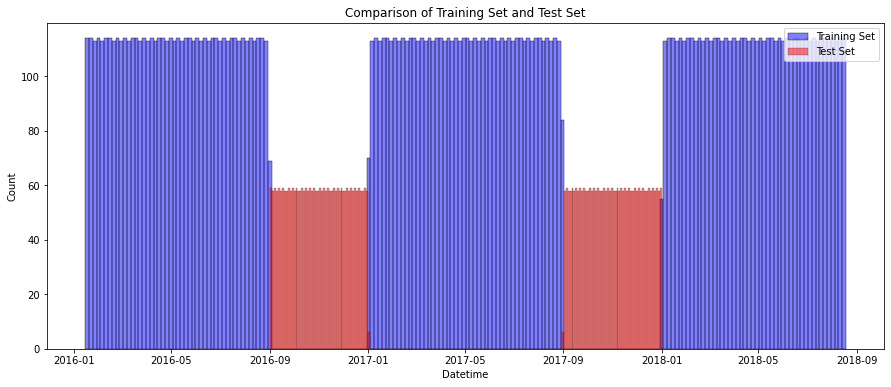

In [4]:
plt.figure(figsize=(15, 6))
sns.histplot(data=train, x='date', bins=200, color='blue', alpha=0.5, label='Training Set')
sns.histplot(data=test, x='date', bins=200, color='red', alpha=0.5, label='Test Set')

plt.title('Comparison of Training Set and Test Set')
plt.xlabel('Datetime')
plt.ylabel('Count')

plt.legend()
plt.show()

<div class="alert alert-success">
<b>Reviewer's comment</b>

Nice visualization!
    

</div>

In [5]:
train.iloc[5518:5523, 0:3]

,date,final.output.concentrate_ag,final.output.concentrate_pb
5518,2016-08-31 21:59:59,5.664237,10.021368
5519,2016-08-31 22:59:59,6.066618,9.908392
5520,2016-08-31 23:59:59,7.108574,10.110568
5521,2017-01-01 00:59:59,9.849632,8.437286
5522,2017-01-01 01:59:59,8.415084,8.927103


In [6]:
test.iloc[2925:2930, 0:3]

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant
2925,2016-12-31 21:59:59,132.630897,8.998328
2926,2016-12-31 22:59:59,127.775871,8.979377
2927,2016-12-31 23:59:59,127.135359,8.981477
2928,2017-09-01 00:59:59,189.345462,5.997663
2929,2017-09-01 01:59:59,199.767960,5.934489


The distribution below is how the training and test data been chosen. They don't have any overlaps.

### Check that recovery is calculated correctly.

I'll use the training set, calculate recovery for the `rougher.output.recovery` feature.

According to the formula

$$Recovery = \frac{C * (F - T)}{F*(C-T)}*100%$$

* C — share of gold in the concentrate right after flotation (for finding the rougher concentrate recovery)/after purification (for finding the final concentrate recovery)
* F — share of gold in the feed before flotation (for finding the rougher concentrate recovery)/in the concentrate right after flotation (for finding the final concentrate recovery)
* T — share of gold in the rougher tails right after flotation (for finding the rougher concentrate recovery)/after purification (for finding the final concentrate recovery)

Specificly, we can use these columns to represent C, F, and T directly.

|Stage| Rougher | Purification|
|--   |  --     |  --        |
| C   |`rougher.output.concentrate_au`| `final.output.concentrate_au`|
| F   |`rougher.input.feed_au` | `rougher.output.concentrate_au`|
| T   |`rougher.output.tail_au`| `final.output.tail_au`|

In [7]:
# Make a subset to drop N/A easily
subset_columns = ['rougher.output.recovery', 'rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au']
subset_for_calculating_recovery = train.loc[:, subset_columns].dropna(axis=0)
subset_for_calculating_recovery.shape

(14287, 4)

In [8]:
C = subset_for_calculating_recovery['rougher.output.concentrate_au']
F = subset_for_calculating_recovery['rougher.input.feed_au']
T = subset_for_calculating_recovery['rougher.output.tail_au']
subset_for_calculating_recovery['rougher.output.recovery.manually'] = 100 * ((C*(F-T))/(F*(C-T)))
subset_for_calculating_recovery.head()

,rougher.output.recovery,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au,rougher.output.recovery.manually
0,87.107763,19.793808,6.486150,1.170244,87.107763
1,86.843261,20.050975,6.478583,1.184827,86.843261
2,86.842308,19.737170,6.362222,1.162562,86.842308
3,87.226430,19.320810,6.118189,1.079755,87.226430
4,86.688794,19.216101,5.663707,1.012642,86.688794


Find the MAE between calculations and the feature values. 

In [9]:
recovery_mae = mean_absolute_error(subset_for_calculating_recovery['rougher.output.recovery'],subset_for_calculating_recovery['rougher.output.recovery.manually'])
print(recovery_mae)

9.303415616264301e-15


The result of MAE between calculations and the original feature is extremely small, it prove that the original recovery is calculated correctly. I'll use the original feature in the next steps.

### Analyze the features not available in the test set.

The number of columns between `train` and `test` are not same. Let's see the difference.

In [10]:
train_columns = train.columns
test_columns = test.columns
columns_differ1 = train_columns[~np.isin(train_columns, test_columns)]
columns_differ2 = test_columns[~np.isin(test_columns, train_columns)]
print(len(columns_differ1), len(columns_differ2))

34 0


There are 34 columns in `train` file but not in `test` file.

The absent features in `test` file are type of 'output' and 'calculation'. The target columns, 'recovery', are not in the `test` file either.

## Analyze the data

### Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage

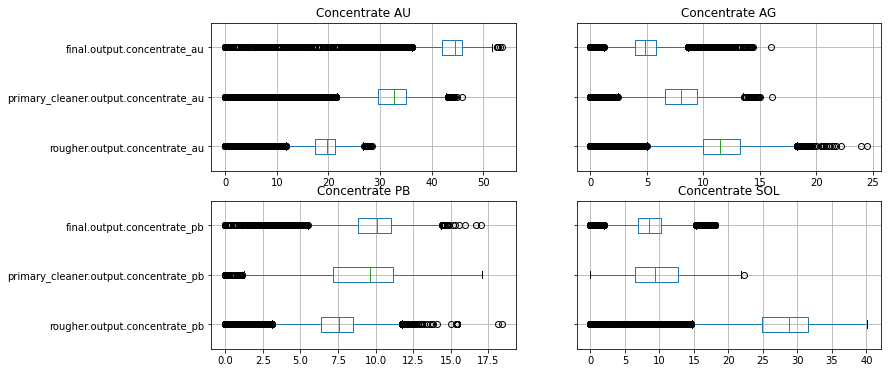

In [11]:
stages = ["rougher.output.", "primary_cleaner.output.", "final.output."]
metals = ['concentrate_au',"concentrate_ag", 'concentrate_pb', 'concentrate_sol']

concentrate_au_stages = [i+metals[0] for i in stages]
concentrate_ag_stages = [i+metals[1] for i in stages]
concentrate_pb_stages = [i+metals[2] for i in stages]
concentrate_sol_stages = [i+metals[3] for i in stages]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,6))
train[concentrate_au_stages].boxplot(ax=axes[0, 0], vert=False)
train[concentrate_ag_stages].boxplot(ax=axes[0, 1], vert=False)
train[concentrate_pb_stages].boxplot(ax=axes[1, 0], vert=False)
train[concentrate_sol_stages].boxplot(ax=axes[1, 1], vert=False)

axes[0, 0].set_title('Concentrate AU')
axes[0, 1].set_title('Concentrate AG')
axes[1, 0].set_title('Concentrate PB')
axes[1, 1].set_title('Concentrate SOL')
axes[0, 1].set_yticklabels([])
axes[1, 1].set_yticklabels([])
plt.show()

We can obtain from the plots above that as the purification process going from 'Floatation', 'Primary Cleaner' to 'Final', the concentrate of AU is increasing and the concentrate of AG is decreasing, while the concentrate of PB stays in the same range although the box between 25% and 75% is increasing slightly.

For the concentrate of SOL, there is a significant decay after primary cleaner stage. But the concentrate distribution is almost the same after the final stage except it has higher convergent.

### Compare the feed particle size distributions in the training set and in the test set. 

There are two feed particle processes in both `train` and `test` files, they are `rougher.input.feed_size` and `primary_cleaner.input.feed_size` 

In [12]:
rougher_feed_size = pd.DataFrame({'Train': train['rougher.input.feed_size'], 'Test': test['rougher.input.feed_size']})
primary_feed_size = pd.DataFrame({'Train': train['primary_cleaner.input.feed_size'], 'Test': test['primary_cleaner.input.feed_size']})

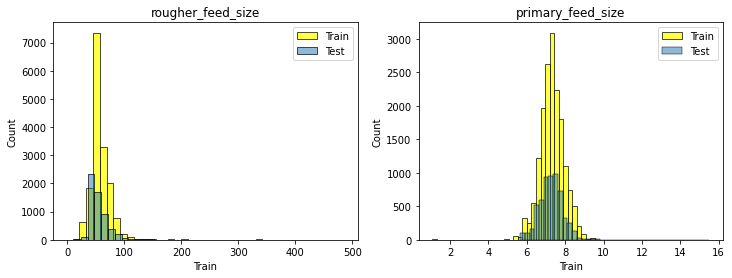

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
sns.histplot(rougher_feed_size['Train'], bins=40, label="Train", color='yellow', kde=False, ax=axes[0])
sns.histplot(rougher_feed_size['Test'], bins=40, label="Test", alpha=0.5, kde=False, ax=axes[0])
sns.histplot(primary_feed_size['Train'], bins=40, label="Train", color='yellow', kde=False, ax=axes[1])
sns.histplot(primary_feed_size['Test'], bins=40, label="Test", alpha=0.5, kde=False, ax=axes[1])

axes[0].set_title('rougher_feed_size')
axes[1].set_title('primary_feed_size')
axes[0].legend()
axes[1].legend()

plt.show()

We can see that for `rougher_feed_size`, the train and test set have right lean distribution slightly. But the mean of train set is a little more than test set. For `primary_feed_size`, they have the same distribution.

To make the measurement more reasonal, I'll introduce the hypothesis test to measure their means and the distribution. I'll choose the Kolmogorov-Smirnov test, it can test whether two samples are come from one distribution.

$H_0$: The means of distributions of these two sets are the same

$H_1$: The means of distributions of these two sets are not the same

$\alpha = 0.05$

In [14]:
def ks_test(a, b):
    alpha = 0.05

    results = st.kstest(a, b)
    #results = st.ttest_ind(a, b, equal_var=False)
    print('p-value:', results.pvalue)

    if results.pvalue < alpha:
        print("We reject the null hypothesis")
    else:
        print("We can't reject the null hypothesis")

Rougher

In [15]:
rougher_test = rougher_feed_size['Test'].dropna()
rougher_train = rougher_feed_size['Train'].dropna()
ks_test(rougher_test, rougher_train)

p-value: 5.871332318176002e-140
We reject the null hypothesis


Primary cleaner

In [16]:
primary_train = primary_feed_size['Train'].dropna()
primary_test = primary_feed_size['Test'].dropna()
ks_test(primary_train, primary_test)

p-value: 1.20224761832344e-10
We reject the null hypothesis


According to the results, the feed size between training and test sets are with different distribution in both Rougher and Primary Cleaner stages.

#### Validate the point with dummy datasets
To prove the KS test validity, I'll regenerate the train and test set.

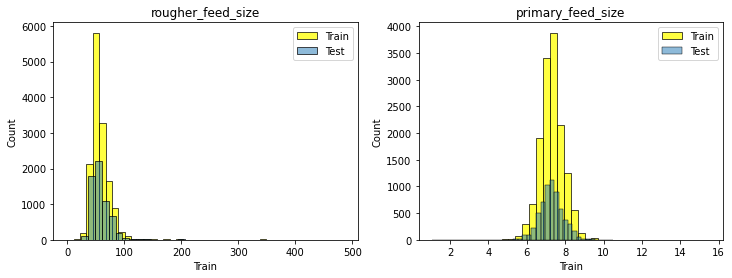

In [17]:
# dummy df for trial
trial_df = full[['date', 'rougher.input.feed_size', 'primary_cleaner.input.feed_size', 'final.output.recovery']].dropna()
trial_X = trial_df.drop('final.output.recovery', axis=1)
trial_y = trial_df['final.output.recovery']
trial_X_train, trial_X_test, trial_y_train, trial_y_test = train_test_split(trial_X, trial_y, test_size=0.3, random_state=42)
# Pick object columns
trial_rougher_feed_size = pd.DataFrame({'Train': trial_X_train['rougher.input.feed_size'], 'Test': trial_X_test['rougher.input.feed_size']})
trial_primary_feed_size = pd.DataFrame({'Train': trial_X_train['primary_cleaner.input.feed_size'], 'Test': trial_X_test['primary_cleaner.input.feed_size']})
# plot the histogram
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
sns.histplot(trial_rougher_feed_size['Train'], bins=40, label="Train", color='yellow', kde=False, ax=axes[0])
sns.histplot(trial_rougher_feed_size['Test'], bins=40, label="Test", alpha=0.5, kde=False, ax=axes[0])
sns.histplot(trial_primary_feed_size['Train'], bins=40, label="Train", color='yellow', kde=False, ax=axes[1])
sns.histplot(trial_primary_feed_size['Test'], bins=40, label="Test", alpha=0.5, kde=False, ax=axes[1])

axes[0].set_title('rougher_feed_size')
axes[1].set_title('primary_feed_size')
axes[0].legend()
axes[1].legend()

plt.show()


It looks more reasonal.

In [18]:
ks_test(trial_X_train['rougher.input.feed_size'], trial_X_test['rougher.input.feed_size'])

p-value: 0.0557964676197612
We can't reject the null hypothesis


In [19]:
ks_test(trial_X_train['primary_cleaner.input.feed_size'], trial_X_test['primary_cleaner.input.feed_size'])

p-value: 0.41494799061008825
We can't reject the null hypothesis


I used the same method to check the dummy train and test sets which extracted from the full dataset. This time the hypothesis test told us that these two sets of data samples were with the same distribution. 

It validates the input feed size columns in original train and test sets are not with the same distribution.

### Consider the total concentrations of all substances at different stages

In [20]:
final_concerntrate = full[['final.output.concentrate_ag', 'final.output.concentrate_au', 'final.output.concentrate_pb']]
final_concerntrate['sum'] = full['final.output.concentrate_ag'] + full['final.output.concentrate_au'] + full['final.output.concentrate_pb']

/tmp/ipykernel_91/1742437268.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_concerntrate['sum'] = full['final.output.concentrate_ag'] + full['final.output.concentrate_au'] + full['final.output.concentrate_pb']


In [21]:
final_concerntrate[final_concerntrate['final.output.concentrate_ag']==0]

,final.output.concentrate_ag,final.output.concentrate_au,final.output.concentrate_pb,sum
99,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0
101,0.0,0.0,0.0,0.0
102,0.0,0.0,0.0,0.0
103,0.0,0.0,0.0,0.0
...,...,...,...,...
17912,0.0,0.0,0.0,0.0
17913,0.0,0.0,0.0,0.0
17914,0.0,0.0,0.0,0.0
17915,0.0,0.0,0.0,0.0


In [22]:
#Create function to get total concentration of all metals at certain stages.
def metal_concen_sum(df, stage):
    metal_handles = ['_ag', '_au', '_pb']
    total_concen = df[stage+metal_handles[0]] + df[stage+metal_handles[1]] + df[stage+metal_handles[2]]
    return total_concen

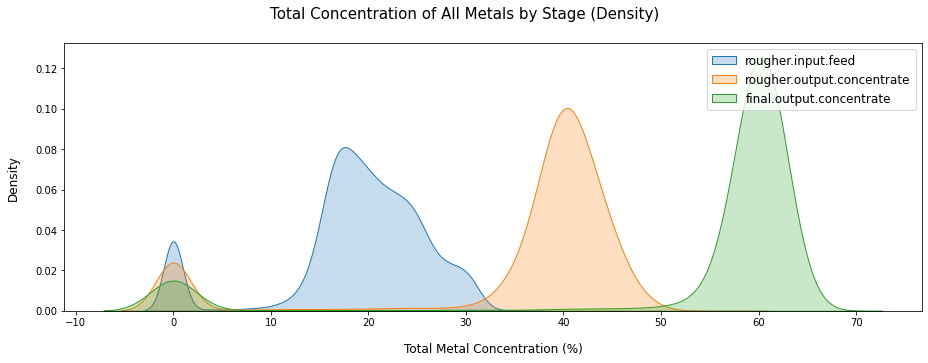

In [23]:
#Create plot to visualize total concentration of all metals at certain stages.
fig = plt.figure(figsize=(13, 5))
fig.suptitle('Total Concentration of All Metals by Stage (Density)', fontsize=15, y=1)

sns.kdeplot(metal_concen_sum(full, 'rougher.input.feed'), label='rougher.input.feed', fill=True)
sns.kdeplot(metal_concen_sum(full, 'rougher.output.concentrate'), label='rougher.output.concentrate', fill=True)
sns.kdeplot(metal_concen_sum(full, 'final.output.concentrate'), label='final.output.concentrate', fill=True)
plt.legend(fontsize=12)
plt.xlabel('Total Metal Concentration (%)', fontsize=12, labelpad = 15)
plt.ylabel('Density', fontsize=12, labelpad=15)
    
plt.tight_layout()
plt.show()

We can find there are many zero values in three stages.

In [24]:
full[full['rougher.input.feed_au'] == 0]

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
99,2016-01-19 03:00:00,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,...,13.985160,-799.601232,12.036072,-603.234250,9.974968,-497.092974,7.953962,-499.698442,11.941642,-598.541756
100,2016-01-19 04:00:00,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,...,14.034374,-799.600946,12.040491,-623.446329,9.898782,-499.623262,7.979302,-500.283366,11.959950,-600.998301
101,2016-01-19 05:00:00,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,...,13.943929,-799.600659,12.040238,-638.103348,9.956309,-499.791870,7.978806,-500.202026,11.987839,-600.302819
102,2016-01-19 06:00:00,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,...,14.040873,-799.600372,12.030771,-641.310327,9.966952,-499.842458,8.053455,-499.588522,11.987935,-600.523057
103,2016-01-19 07:00:00,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,...,13.972371,-799.600085,12.021058,-641.457227,10.033820,-501.291438,7.985956,-499.934267,12.027556,-600.108918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17908,2018-01-30 03:59:59,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,...,20.005303,-500.893527,14.922286,-500.230461,10.909829,-500.314837,9.007956,-500.153163,10.988968,-500.387261
17909,2018-01-30 04:59:59,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,...,19.962859,-655.489381,14.956567,-524.758657,10.961487,-500.066426,9.004925,-500.040902,10.961121,-500.023096
17910,2018-01-30 05:59:59,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,...,20.017100,-523.801393,15.013965,-499.995375,10.991333,-499.941268,9.062215,-499.992738,10.996987,-499.871678
17911,2018-01-30 06:59:59,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,...,19.947963,-521.792599,15.041185,-500.303435,10.980523,-500.095725,9.041985,-499.916563,11.010581,-500.083532


I trid to print some samples which `rougher.input.feed_au` equals to zero, and found that not only this column was zero, other concertrate columns were zero too. Additionally, zero values happens continuously in date time. 

The more important issue is that zero values in these columns conduct NaN values of the targets of recovery. Therefore it's necessary to address this issue.

### Addressing the NA and zero value issues

#### Test set

Add target columns to the test set

In [25]:
test = pd.merge(test, full[['date', 'rougher.output.recovery', 'final.output.recovery']], left_on='date', right_on='date', how='left')
test.shape

(5856, 55)

In [26]:
mask = (test['rougher.input.feed_ag'] == 0) | (test['rougher.input.feed_pb'] == 0) | (test['rougher.input.feed_au'] == 0)

In [27]:
#test[mask][['date', 'rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_au', 'rougher.output.recovery', 'final.output.recovery']]

Delete zero values

In [28]:
test = test[~mask]
test.shape

(5487, 55)

Address the NA values

In [29]:
test.isna().sum()

date                                            0
primary_cleaner.input.sulfate                  30
primary_cleaner.input.depressant               33
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                 30
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.floatbank8_b_level       16
primary_cleaner.state.floatbank8_c_air         16
primary_cleaner.state.floatbank8_c_level       16
primary_cleaner.state.floatbank8_d_air         16
primary_cleaner.state.floatbank8_d_level       16
rougher.input.feed_ag                          16
rougher.input.feed_pb                          16
rougher.input.feed_rate                        23
rougher.input.feed_size                        17
rougher.input.feed_sol                         67
rougher.input.feed_au                          16
rougher.input.floatbank10_sulfate              27


Since we cann't train the model if the target is missing, so I'll drop the NA value in target columns.

In [30]:
test.dropna(subset=['rougher.output.recovery', 'final.output.recovery'], inplace=True)

Since the whole gold recovery process is a time series workflow, all material parameters are asympotic by time, so I'll use the data from the previous moment to fill in the missing values.

In [31]:
test.fillna(method='ffill', inplace=True)

#### Training set

In the default setting, there are 34 columns in the training set but not in the test set. The model won't fit the test set if I keep them. So I'll delete them and keep the same features in both training and test set.

In [32]:
columns = test.columns
train = train[columns]
train.shape

(16860, 55)

Then I'll address the zero and NA values similar to the test set 

In [33]:
# Delete the zero values in feed metal columns
mask_train = (train['rougher.input.feed_ag'] == 0) | (train['rougher.input.feed_pb'] == 0) | (train['rougher.input.feed_au'] == 0)
train = train[~mask_train]

# Drop missing values in target columns
train.dropna(subset=['rougher.output.recovery', 'final.output.recovery'], inplace=True)

# Fill missing values in other columns
train.fillna(method='ffill', inplace=True)

In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14149 entries, 0 to 16859
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        14149 non-null  datetime64[ns]
 1   primary_cleaner.input.sulfate               14149 non-null  float64       
 2   primary_cleaner.input.depressant            14149 non-null  float64       
 3   primary_cleaner.input.feed_size             14149 non-null  float64       
 4   primary_cleaner.input.xanthate              14149 non-null  float64       
 5   primary_cleaner.state.floatbank8_a_air      14149 non-null  float64       
 6   primary_cleaner.state.floatbank8_a_level    14149 non-null  float64       
 7   primary_cleaner.state.floatbank8_b_air      14149 non-null  float64       
 8   primary_cleaner.state.floatbank8_b_level    14149 non-null  float64       
 9   primar

## Build the model

### Preprocessing

Before building the model, I'd like to discuss how to deal with two targets in this project. As we know, a normal regression model only have one target, but in this project we have two. So how to deal with it?

I have mentioned before, the gold recovery process is a time-series workflow, therefore there is a temporal sequence between this two targets. Specifically, the target of `rougher.output.recovery` is right behind the process of flotation and the target of `final.output.recovery` is the end of the whole process. That means we cannot use the parameters of 'cleaner process' to predict the `rougher.output.recovery`, and we have to use the `rougher.output.recovery`, i.e. the first target, to predict the second target.

![img](https://practicum-content.s3.us-west-1.amazonaws.com/resources/moved_ore_1591699963.jpg)

So how to address this issue? My idea is I will separate the training and test set into two stages
* To predict `rougher.output.recovery`: Only use the features of `rougher`
* To predict `final.output.recovery`: Use all features and the prediction of `rougher.output.recovery`.

To do so, it will be more complex than the traditional train-test split method.

In the Rougher stage, I chose the features before the rougher.output.recovery was generated and train a model. Then I saved the prediction of rougher.output.recovery for the next stage.

In the final stage, I used all features but replace the rougher.output.recovery with the predicted values.

As the demonstration below, the predictions, blue vectors, are used to replace `rougher.output.recovery`.  

![img](https://github.com/stemgene/tossprob/blob/main/img/two_targets.png?raw=true)

Firstly, I will prepare two set of training and test sets.

In [35]:
train['date'] = train['date'].apply(lambda x: (x.timestamp() - 1452812400)/3600)
test['date'] = test['date'].apply(lambda x: (x.timestamp() - 1452812400)/3600)

In [36]:
train_cleaned = train.reset_index(drop=True)
test_cleaned = test.reset_index(drop=True)

In [37]:
rougher = ['date','rougher.input.feed_ag','rougher.input.feed_pb', 'rougher.input.feed_rate','rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate','rougher.input.floatbank10_xanthate','rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air','rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air',
       'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air','rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
       'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air','rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air',
       'rougher.state.floatbank10_f_level', 'rougher.output.recovery']
train_rougher = train_cleaned[rougher].copy()
test_rougher = test_cleaned[rougher].copy()
train_rougher.shape

(14149, 24)

In [38]:
X_train_rougher = train_rougher.drop(['rougher.output.recovery'], axis=1)
y_train_rougher = train_rougher['rougher.output.recovery']
X_test_rougher = test_rougher.drop(['rougher.output.recovery'], axis=1)
y_test_rougher = test_rougher['rougher.output.recovery']

Scaling: If the cross validation will be applied, the scaling step should be used in each fold of cross validation. Otherwise it will cause data leak. 

To build the final stage training and test set, we have to obtain the prodiction of the first stage.

### Training

#### Training the first stage

In [40]:
def sMAPE_metric(y_true, y_pred):
    n = len(y_true)
    sum_abs = 0
    for i in range(n):
        differ = np.abs(y_true[i] - y_pred[i]) * 100
        avg = (np.abs(y_true[i]) + np.abs(y_pred[i])) / 2
        if np.isclose(avg, 0): 
            avg = 1e-8  
        sum_abs += (differ / avg)
    score = sum_abs / n
    return score

In [41]:
sMAPE_scorer = make_scorer(sMAPE_metric)
scores = []
models = [LinearRegression(), DecisionTreeRegressor(),RandomForestRegressor(), xgb.XGBRegressor()]
model_names = ['Linear Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
for model in models:  # should use X_train_rougher.values, otherwise index error may happens
    print("The current working model is: ", model)
    # scaling
    scaler = StandardScaler()
    pipeline = Pipeline([('scaler', scaler), ('classifier', model)])
    
    score = cross_val_score(pipeline, X_train_rougher.values, y_train_rougher.values, cv=5, scoring=sMAPE_scorer, error_score='raise')
    scores.append(np.mean(score))
scores_df = pd.DataFrame({'model': model_names, 'score': scores})
scores_df.T

The current working model is:  LinearRegression()
The current working model is:  DecisionTreeRegressor()
The current working model is:  RandomForestRegressor()
The current working model is:  XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)


,0,1,2,3
model,Linear Regression,Decision Tree,Random Forest,XGBoost
score,11.174992,33.401197,16.329216,14.166368


In [ ]:
# numeric_rougher = ['rougher.input.feed_ag','rougher.input.feed_pb', 'rougher.input.feed_rate','rougher.input.feed_size', 'rougher.input.feed_sol',
#        'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate','rougher.input.floatbank10_xanthate','rougher.input.floatbank11_sulfate',
#        'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air','rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air',
#        'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air','rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
#        'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air','rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air',
#        'rougher.state.floatbank10_f_level']
# scaler = StandardScaler()
# scaler.fit(X_train_rougher[numeric_rougher])
# X_train_rougher[numeric_rougher] = scaler.transform(X_train_rougher[numeric_rougher])
# X_test_rougher[numeric_rougher] = scaler.transform(X_test_rougher[numeric_rougher])

We can see that based on the metric of sMAPE, the best the model in this stage is the linear regression, therefore I will use this model to generate the prodiction of the `rougher.output.recovery` and replace the original one in order to train the next model.

In [42]:
model = LinearRegression()
model = model.fit(X_train_rougher.values, y_train_rougher.values)
rougher_output_recovery_train_pred = model.predict(X_train_rougher.values)
rougher_output_recovery_test_pred = model.predict(X_test_rougher.values)  # for calculating the final sMAPE

Make a prediction by `DummyRegressor`

In [52]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr = dummy_regr.fit(X_train_rougher.values, y_train_rougher.values)
dummy_rougher_test_pred = dummy_regr.predict(X_test_rougher.values)

#### Training the final stage

In [43]:
train_final = train_cleaned.copy()
test_final = test_cleaned.copy()
# replace 'rougher.output.recovery' with prediction from the first stage
train_final['rougher.output.recovery'] = rougher_output_recovery_train_pred
test_final['rougher.output.recovery'] = rougher_output_recovery_test_pred


X_train_final = train_final.drop(['final.output.recovery'], axis=1)
y_train_final = train_final['final.output.recovery']
X_test_final = test_final.drop(['final.output.recovery'], axis=1)
y_test_final = test_final['final.output.recovery']

In [ ]:
# numeric_final = ['primary_cleaner.input.sulfate','primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
#        'primary_cleaner.input.xanthate','primary_cleaner.state.floatbank8_a_air','primary_cleaner.state.floatbank8_a_level',
#        'primary_cleaner.state.floatbank8_b_air','primary_cleaner.state.floatbank8_b_level','primary_cleaner.state.floatbank8_c_air',
#        'primary_cleaner.state.floatbank8_c_level','primary_cleaner.state.floatbank8_d_air','primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
#        'rougher.input.feed_pb', 'rougher.input.feed_rate','rougher.input.feed_size', 'rougher.input.feed_sol','rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
#        'rougher.input.floatbank10_xanthate','rougher.input.floatbank11_sulfate','rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
#        'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air','rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air',
#        'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air','rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air',
#        'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air','rougher.state.floatbank10_f_level','secondary_cleaner.state.floatbank2_a_air',
#        'secondary_cleaner.state.floatbank2_a_level','secondary_cleaner.state.floatbank2_b_air','secondary_cleaner.state.floatbank2_b_level',
#        'secondary_cleaner.state.floatbank3_a_air','secondary_cleaner.state.floatbank3_a_level','secondary_cleaner.state.floatbank3_b_air',
#        'secondary_cleaner.state.floatbank3_b_level','secondary_cleaner.state.floatbank4_a_air','secondary_cleaner.state.floatbank4_a_level','secondary_cleaner.state.floatbank4_b_air',
#        'secondary_cleaner.state.floatbank4_b_level','secondary_cleaner.state.floatbank5_a_air',
#        'secondary_cleaner.state.floatbank5_a_level','secondary_cleaner.state.floatbank5_b_air','secondary_cleaner.state.floatbank5_b_level',
#        'secondary_cleaner.state.floatbank6_a_air','secondary_cleaner.state.floatbank6_a_level','rougher.output.recovery']
# scaler = StandardScaler()
# scaler.fit(X_train_final[numeric_final])
# X_train_final[numeric_final] = scaler.transform(X_train_final[numeric_final])
# X_test_final[numeric_final] = scaler.transform(X_test_final[numeric_final])

In [44]:
scores = []
models = [LinearRegression(), DecisionTreeRegressor(),RandomForestRegressor(), xgb.XGBRegressor()]
model_names = ['Linear Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
for model in models:  # should use X_train_rougher.values, otherwise index error may happens
    print("The current working model is: ", model)
    scaler = StandardScaler()
    pipeline = Pipeline([('scaler', scaler), ('classifier', model)])
    score = cross_val_score(model, X_train_final.values, y_train_final.values, cv=5, scoring=sMAPE_scorer, error_score='raise')
    scores.append(np.mean(score))
scores_df = pd.DataFrame({'model': model_names, 'score': scores})
scores_df.T

The current working model is:  LinearRegression()
The current working model is:  DecisionTreeRegressor()
The current working model is:  RandomForestRegressor()
The current working model is:  XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)


,0,1,2,3
model,Linear Regression,Decision Tree,Random Forest,XGBoost
score,11.11011,20.930045,11.588377,13.727861


## Calculating the final sMAPE by the test set

### Calculating the score of 'rougher' stage

I've generated the prediction of X_test_rougher at #3.2.1

In [45]:
score_rougher = sMAPE_metric(y_test_rougher, rougher_output_recovery_test_pred)

In [53]:
control_group_score_rougher = sMAPE_metric(y_test_rougher, dummy_rougher_test_pred)

### Calculating the score of final stage

In [46]:
model = LinearRegression()
model = model.fit(X_train_final.values, y_train_final.values)
y_test_pred_final = model.predict(X_test_final)
score_final = sMAPE_metric(y_test_final, y_test_pred_final)

In [54]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr = dummy_regr.fit(X_train_final.values, y_train_final.values)
dummy_final_test_pred = dummy_regr.predict(X_test_final)
contro_group_score_final = sMAPE_metric(y_test_final, dummy_final_test_pred)

### Calculating the combined sMAPE score

In [47]:
combined_score = 0.25 * score_rougher + 0.75 * score_final
print(combined_score)

9.627701465108698


In [55]:
control_group_combined_score = 0.25 * control_group_score_rougher + 0.75 * contro_group_score_final
print(control_group_combined_score)

10.28963037602106


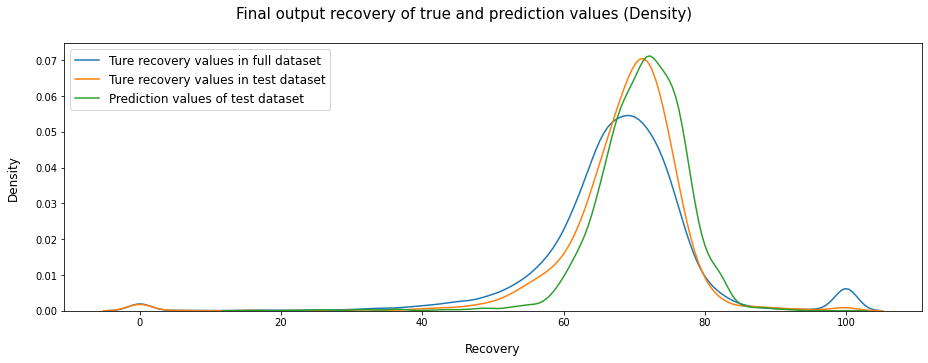

In [57]:
fig = plt.figure(figsize=(13, 5))
fig.suptitle('Final output recovery of true and prediction values (Density)', fontsize=15, y=1)
sns.kdeplot(full['final.output.recovery'], label='Ture recovery values in full dataset')
sns.kdeplot(y_test_final, label='Ture recovery values in test dataset')
sns.kdeplot(y_test_pred_final, label='Prediction values of test dataset')

sns.kdeplot()
plt.legend(fontsize=12)
plt.xlabel('Recovery', fontsize=12, labelpad = 15)
plt.ylabel('Density', fontsize=12, labelpad=15)
    
plt.tight_layout()
plt.show()

It's not a good enough model, the error accounts for non-negligible proportion。

I made a as a control group 

## Conclusion

In this project, I mainly finished three tasks.

* Prepare the data

    Unlike previous projects which provide a single dataset, this time a train set and a test set have been given, and they are different in features. Additionally, in order to follow and answer the project instuction questions, it won't be clear if I use the traditional process of data cleaning, such as check duplicated, missing value and so on.
    
    Then main data validity issue are missing and zero values on important features. According to the distribution plot, I found the concentrate of metals in some stages are zero at the same time. As they are the essential raw materials, their coefficients are crutial too, if their values are zero, it's impossible to calculate their coefficients. Therefore I decide to delete those rows with zero values.
    
    To address the missing values, if there are missing values in the target columns, I drop them directly. Otherwise, due to the whole gold recovery process is time series, I filled the missing values with the pervious time.
    

* Analyze the data

    I'm confused with the question of comparing the feed size distributions. I proposed a hypothesis and calculated they are not the same mean values or distribution. If they are not belong to the same distribution, I should generate new train and test sets from the full dataset. But it conflict with the project instruction. It will be appreciated if you could give me some advice.
    

* Build the model and calculate the sMAPE metric

    The most challenge is how to deal with two targets. I designed an experiment that divide the targets into two seperate stages. 
    
    In the Rougher stage, I chose the features before the `rougher.output.recovery` was generated and train a model. Then I saved the prediction of `rougher.output.recovery` for the next stage. 
    
    In the final stage, I used all features but replace the `rougher.output.recovery` with the predicted values.
    
    I applied the cross validation approach to choose the best model from 4 regression models. Unexpectedly, the simplest one, the linear regression, was the winner.
    
    Finally, I calculated the combined sMAPE score. It showed the model was not good enough.
    

* Future optimization plan


    * Fine tuning the models. Although the linear regression is the best model through the cross validation selection, it performed worse than Randome Forest and XGBoot when abandoned the cross validation. A better model selection method or fine tuning the hyperparameters might work for the metrics.
    
    * Time series models. I should consider the whole process as assembly line. The parameters of a certian hour should affect the target from subsequent hours rather than the same hour (row). Therefore a time series solution might be better. 
    
    * Feature engineering. There are some optimization options on feature engineering, such as fill missing values with the mean or median, check the correlationship between features.